# Use a shallow neural network to search for A. varius vocalizations
This notebook demmonstrates how we trained and applied a MLP classifier to our data.

In [74]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
from glob import glob
import bioacoustics_model_zoo as bmz
from tqdm import tqdm
from time import time as timer
from opensoundscape import Audio, Spectrogram
import IPython.display as ipd
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import average_precision_score, roc_auc_score

## Set up project directories and load embedding files

In [16]:
# Define data and output directories (adjust these paths as needed)
# Embeddings directory (assumed to be generated in previous steps)
TEST_EMB_DIR = Path("sample_embeddings")
TRAIN_EMB_DIR = Path("sample_templates")

In [27]:
# Function to load all embedding CSV files into one DataFrame.
def load_embeddings(emb_dir=TRAIN_EMB_DIR):
    """
    Load all pre-generated embeddings from CSV files in emb_dir.
    
    Parameters:
        emb_dir (Path): Path to the directory containing embedding CSV files.
    
    Returns:
        Pandas DataFrame containing concatenated embeddings.
    """
    # Recursively find all CSV files ending with '_embeddings.csv'
    embedding_files = sorted(emb_dir.glob("*.csv"))
    
    # List to hold each file's DataFrame
    df_list = []
    for file in embedding_files:
        df = pd.read_csv(file, index_col=['file','start_time','end_time'])
        df_list.append(df)
    
    # Combine all into one DataFrame (if needed)
    return pd.concat(df_list)

In [41]:
train_embs = load_embeddings()
embs_labels = pd.DataFrame({'avar':1}, index=train_embs.index)

## Initialize and Train MLP Model

In [12]:
"""
We initialize a Multilayer Perceptron model with 2 hidden layers, each with 100 neurons.
In our study, we also tested a similarly-initialized model with 0 hidden layers.
"""
# Create model
model = MLPClassifier(hidden_layer_sizes=(100, 100), alpha=1, 
                      max_iter=1000, random_state=42)

In [42]:
# Extract feature embeddings & labels from training data
train_features = train_embs.values
train_labels = embs_labels['avar']

# Create a pipeline that scales the data and then trains the MLPClassifier
pipeline_clf = make_pipeline(StandardScaler(), model)
# Fit the model using the created pipeline
pipeline_clf.fit(train_features, train_labels)
# Predict on training data
predictions_train = pipeline_clf.predict_proba(train_features)
# Build a DataFrame from returned predictions with the same index as the labels
pred_train_df = pd.DataFrame(predictions_train, index=train_labels.index)
# Join labels to predictions for evaluation
pred_df = pred_train_df.join(train_labels)

In [51]:
# Report model's average precision using ground truth labels and prediction probabilities
average_precision_train = average_precision_score(train_labels, pred_train_df[1])
print("Average precision (train):", average_precision_train)

Average precision (train): 1.0


## Analyze test data

In [53]:
def readcsv(file_path):
    """
    Facilitates reading in a CSV file and setting the first three columns as index.
    
    Parameters:
        file_path (str): Path to the CSV file
    
    Returns:
        The CSV file's data in a DataFrame with a MultiIndex from the first three columns.
    """
    return pd.read_csv(file_path, index_col=[0, 1, 2])


def embs_to_df(dir_path=TEST_EMB_DIR):
    """
    Read all CSV files from a directory and concatenate them into a single DataFrame.
    This is useful when predicting on multiple files.
    
    Parameters:
        card_path (str): Path to the folder containing embedding CSV files.
    
    Returns:
        Concatenated DataFrame from all CSVs, with missing values dropped.
    """
    # List all CSV files in the given directory
    csv_files = glob(f'{dir_path}/*.csv')
    
    # Read all CSV files into DataFrames using a list comprehension
    dfs = [readcsv(file) for file in csv_files]
    
    # Concatenate all DataFrames and drop any rows with missing values
    combined_df = pd.concat(dfs).dropna()
    return combined_df

In [59]:
def process_files(folder=TEST_EMB_DIR, clf=model):
    """
    Process embedding CSV files in the provided directory by reading and concatenating them,
    and then predicting on them with the classifier clf.
    
    Parameters:
        card_path (str): Path to the folder containing CSV embedding files.
    
    Returns:
        (card_path, DataFrame of predicted probabilities), or (card_path, None) if error
    """
    test_df = embs_to_df(folder)

    # Convert data to an array and predict using our classifier (clf)
    X_test = test_df.values
    preds_test = clf.predict_proba(X_test)
    
    # Build a DataFrame from the predictions, preserving the original index from test_df.
    preds_df = pd.DataFrame(preds_test, index=test_df.index)
    return folder, preds_df

In [63]:
# Run analysis
target_dir, df = process_files()

## Inspect highest-scoring clips

In [76]:
# To better "see" the call, we extend the clip by 0.5s in the beginning and at the end.
display_clip_duration = 3

def display_results(result_tuple, play_audio=True):
    """
    - Calculate and plot the spectrogram of the audio clip selected for review.
    - Report relevant information about the clip, including its RIBBIT score.
    - If desired, listen to the audio clip.
    """
    print(f"Displaying audio file: {result_tuple[0]} at {result_tuple[1]} seconds:")
    # Load in desired audio clip (0.5s before true start time)
    audio = Audio.from_file(result_tuple[0], 
                            offset=result_tuple[1], 
                            duration=display_clip_duration)
    # Display spectrogram from our audio clip
    Spectrogram.from_audio(
        audio,
        window_samples=256,
        overlap_fraction=.9
    ).bandpass(0,5000).plot()
    # Play audio! :)
    if play_audio:
        ipd.display(ipd.Audio(audio.samples,rate=audio.sample_rate,autoplay=False))
    print(f"This clip got a score of {result_tuple[2]}.\n\n")

Displaying audio file: sample_audio/test_dset_1.wav at 45.0 seconds:


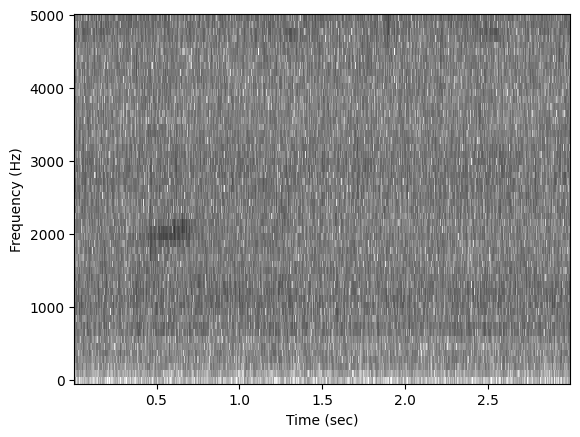

This clip got a score of 0.019099984578238905.


Displaying audio file: sample_audio/test_dset_1.wav at 27.0 seconds:


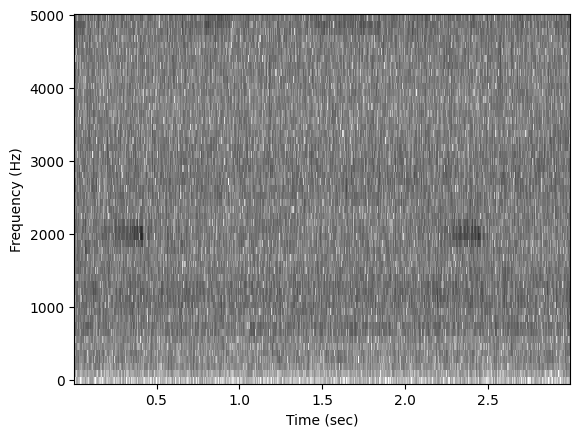

This clip got a score of 0.01903319926201871.


Displaying audio file: sample_audio/test_dset_3.wav at 0.0 seconds:


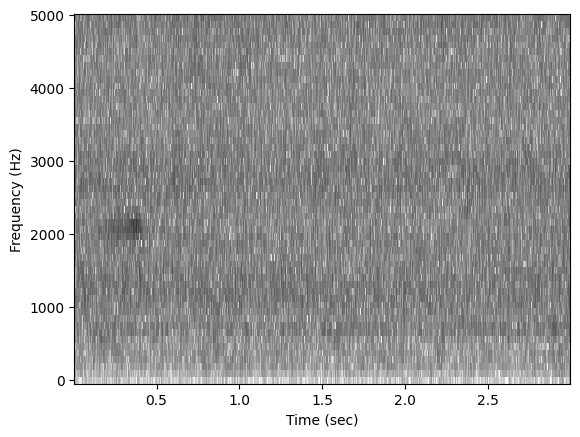

This clip got a score of 0.01902213333038199.




In [77]:
"""
Take a closer look at our last score DataFrame to display a desired 
number of highest-scoring clips from the latest file analyzed.
"""
# Set desired number of review clips.
n_review_clips = 3
# Subset DataFrame to that number of high-scoring clips.
clips_to_review = df.sort_values(by=[1], ascending=False).head(n_review_clips)
# Check out your results!
for index, row in clips_to_review.reset_index().iterrows():
    display_results(tuple(row[["file","start_time",1]]), play_audio=True)